In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import re
from scipy import stats, special
from scipy.stats import norm as normpdf
import seaborn.apionly as sns
from tqdm import tqdm
from collections import namedtuple

Plot = namedtuple('Plot', ['x_label', 'binning', 'f', 'convert', 'ps'])
Plot.__new__.__defaults__ = (None, None, None, None, None, '')

/afs/cern.ch/user/d/dmuller/work/anaconda3/envs/k3pi_python3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [11]:
def weight_sn(df):
    ncluster = df.groupby('cluster').size()

    sampled = ncluster.sample(n=ncluster.index.size, replace=True)
    scount = sampled.groupby(level=0).size()
    scount.name = 'cw'

    df = df.join(scount, on='cluster')
    df.cw.fillna(0, inplace=True)
    df['weight'] = 0.

    return df.cw


def statistics(pull):
    n = len(pull)
    ratio = np.exp(special.gammaln(n/2.)-special.gammaln((n-1)/2.))
    mean = np.mean(pull)
    std = np.std(pull)
    mean_e = std/np.sqrt(n)
    std_e = std*np.sqrt(1-2./(n-1)*(ratio)**2.)
    return mean, mean_e, std, std_e


def lhcb_stamp(ax, meson=None, year=None, xy=(0.05, 0.87), prel=None):
    """Add the LHCb stamp to the plot, with the beam energy for the year."""
    lhcb = r'LHCb Simulation'

    ax.annotate(lhcb,
                xy=(xy[0], xy[1]), xycoords='axes fraction',
                fontsize=42, verticalalignment='bottom')


def y_margin_scaler(ax, lf=0.1, hf=0.2, la=False, ha=False, log=False):
    if la and ha:
        ax.set_ylim((lf, hf))
        return

    mi, ma = ax.yaxis.get_data_interval()

    if log:
        if la:
            new_mi = lf
        else:
            new_mi = lf * ma
        delta = np.abs(np.log10(ma)-np.log10(new_mi))/(1. - hf)
        new_ma = 10.**((np.log10(new_mi) + delta))

    elif la:
        new_mi = lf
        new_ma = lf + (ma-lf)/(1. - hf)
    elif ha:
        new_ma = hf
        new_mi = hf - (hf-mi)/(1. - lf)
    else:
        rel_hf = hf/(1-lf-hf)
        rel_lf = lf/(1-lf-hf)
        new_ma = ma + (ma - mi)*rel_hf
        new_mi = mi - (ma - mi)*rel_lf

    ax.set_ylim((new_mi, new_ma))


def pull_plot(ax, fast, nominal, err, width, xs, **kwargs):
    """Plot the error-normalised PDF-data difference on the axis."""
    pulls = [0 if y == 0 else (x - y)/e
             for x, y, e in zip(nominal, fast, err)]
    xs = xs - width/2.

    opts = dict(color='#222222', edgecolor='#222222', linewidth=1)
    opts.update(kwargs)
    opts['alpha'] = 0.5
    opts['linewidth'] = 0

    # Add pull histogram
    # bins, edges = np.histogram(pulls[pulls != 0], range=(-5,5), bins=20)

    pulls = np.array(pulls)
    bins, edges = np.histogram(pulls[pulls != 0], range=(-5,5), bins=20, normed=True)
    _, _, pull_std, pull_std_e = statistics(pulls[pulls != 0])

    ax.set_ylim(-5, 5)
    arr = None
    values = None
    if np.sum(bins > 0) > 5:
        x_min, x_max = ax.get_xlim()
        pys = np.linspace(-5,5,1000)
        pxs = normpdf.pdf(pys)
        scale = 1. / np.max(pxs)*(x_max - x_min)*0.25
        pxs = x_max - pxs * scale

        y_low, y_high = edges[:-1], edges[1:]
        x_high = np.ones(len(bins)) * x_max
        x_low = (x_high) - bins*scale
        x_ctr = (x_low + x_high)/2.
        x_wdh = (x_high - x_low)

        ax.bar(x_ctr-x_wdh/2., y_high-y_low, x_wdh, bottom=y_low, color='#006EB6',
            edgecolor='#006EB6', linewidth=0, alpha=0.3, align='edge')

        x_label_pos = x_max-(x_max-x_min)*0.32

        ax.plot(pxs, pys, linewidth=3, color='#006EB6')
        values = r'${:.2f}\pm{:.2f}$'.format(pull_std, pull_std_e)
        # ax.annotate(arr, xy=(x_label_pos, 2.1), fontsize=20, verticalalignment='bottom')

    ax.bar(xs, pulls, width=width/1.1, align='edge', **opts)

    # Plot +/- 2 sigma lines. 95% of the data should be within these lines
    ax.plot([xs[0], xs[-1]+width[-1]], [2, 2], color='red')
    ax.plot([xs[0], xs[-1]+width[-1]], [-2, -2], color='red')
    return values


def plot(fast, nominal, settings, mod_label='Redecay', n_fast=1, n_nom=1, fast_weight=None):

    if mod_label == 'Exclusive':
        fig, ax = plt.subplots(figsize=(10, 8))
    else:
        fig = plt.figure(figsize=(10, 10))
        gs = plt.GridSpec(2, 1, height_ratios=[4, 1])
        gspl = gs[0]
        gspu = gs[1]
        ax = fig.add_subplot(gspl)
        pullax = fig.add_subplot(gspu)

    nbins, xmin, xmax = settings.binning

    if fast_weight is not None:
        h_fast, edges = np.histogram(fast, bins=nbins, range=(xmin, xmax), weights=fast_weight)  # NOQA
        h_fast_sq, _ = np.histogram(fast, bins=nbins, range=(xmin, xmax), weights=fast_weight**2)  # NOQA
    else:
        h_fast, edges = np.histogram(fast, bins=nbins, range=(xmin, xmax))
    h_nom, _ = np.histogram(nominal, bins=nbins, range=(xmin, xmax))
    x_ctr = (edges[1:] + edges[:-1])/2.
    width = (edges[1:] - edges[:-1])
    x_err = width/2.

    if mod_label == 'Exclusive':
        if fast_weight is not None:
            n_fast = np.sum(fast_weight)
        else:
            n_fast = fast.index.size
        n_nom = nominal.index.size

    if fast_weight is not None:
        err_fast = np.sqrt(h_fast_sq)
    else:
        err_fast = np.sqrt(h_fast)
    err_nom = np.sqrt(h_nom)

    h_nom = h_nom*1./float(n_nom)
    err_nom = err_nom / float(n_nom)

    h_fast = h_fast*1./float(n_fast)
    err_fast /= float(n_fast)

    ax.bar(x_ctr-x_err, h_nom, width, color='#D3EFFB',
           label='Nominal', edgecolor='#D3EFFB', align='edge')
    dt_options = dict(
        fmt='o', markersize=5, capthick=1, capsize=0, elinewidth=2,
        color='#006EB6', markeredgecolor='#006EB6')
    ax.errorbar(x_ctr, h_fast, yerr=err_fast, xerr=x_err, label='ReDecay',
                **dt_options)

    if mod_label != 'Exclusive':
        pullax.set_xlim((xmin, xmax))
        extraString = pull_plot(pullax, h_fast, h_nom, np.sqrt(err_fast**2 + err_nom**2),
                width, x_ctr)
        pullax.set_ylabel(r'$\Delta/\sigma$')
        pullax.set_xlabel(settings.x_label)
    else:
        ax.set_xlabel(settings.x_label)
    if extraString is not None:
        ax.plot([],[], 'ro', marker=r'$\sigma_{\mathrm{pull}}$', label=extraString, color='black', markersize=40)
        handles, labels = ax.get_legend_handles_labels()
        # handles = handles[0:2][::-1] + [handles[2]]
        # labels = labels[0:2][::-1] + [labels[2]]
        handles = handles[::-1]
        labels = labels[::-1]
    else:
        handles, labels = ax.get_legend_handles_labels()
        handles = handles[::-1]
        labels = labels[::-1]
    ax.legend(handles, labels, loc='upper right')
    [xtl.set_visible(False) for xtl in ax.get_xticklabels()]
    ax.get_xaxis().get_offset_text().set_visible(False)
    ax.set_xlim((xmin, xmax))
    ax.set_ylabel(r'Arbitrary units')

    if mod_label != 'Exclusive':
        plt.tight_layout()
        gs.tight_layout(fig, pad=0.1)
    y_margin_scaler(ax, hf=0.28, lf=0., la=True)
    #lhcb_stamp(ax)
    return fig, ax




def autocorr(fast, nominal, settings, mod_label='Redecay'):
    fig, ax = plt.subplots(figsize=(10, 10))

    @np.vectorize
    def ac_fast(x):
        return fast.autocorr(x)

    @np.vectorize
    def ac_nominal(x):
        return nominal.autocorr(x)

    x_vals = np.array(range(1, 100))
    ac_f = ac_fast(x_vals)
    ac_n = ac_nominal(x_vals)

    ax.plot(x_vals, ac_n,
            label='Nominal', **dt_options)

    ax.plot(x_vals, ac_f,
            label=mod_label, **dt_options)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='best')
    ax.get_xaxis().get_offset_text().set_visible(False)
    no_unit = re.sub(r'\ \[.+?\]', '', settings.x_label)
    ax.set_ylabel(r'Autocorrelation ' + no_unit)
    ax.set_xlabel(r'Offset')
    ax.set_ylim((-0.1,1.))

    plt.tight_layout()
    return fig


def autocorr_stepped(values, labels):
    fig, ax = plt.subplots(figsize=(10, 10))
    x_vals = np.array(range(1, 100))
    linestyles = ['-', '--', '-.', ':'] + 100*['-']
    linestyles = linestyles[0:len(labels)]
    for lbl, vals, ls in zip(labels, values, linestyles):
        lbl = lbl/5.
        fast = pd.Series(vals.flatten())
        @np.vectorize
        def ac_fast(x):
            return fast.autocorr(x)

        ac = ac_fast(x_vals)

        ax.plot(x_vals, ac, label=f'$\sigma_2/\sigma_1={lbl:.1f}$', linestyle=ls)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='best')
    ax.get_xaxis().get_offset_text().set_visible(False)
    ax.set_ylabel(r'Autocorrelation $R(\tau)$')
    ax.set_xlabel(r'$\tau$')
    ax.set_ylim((-0.1,1.))

    plt.tight_layout()
    return fig


def make(plt_s, fst, nom, mod_label, fst_norm, nom_norm,
         outfile='./dummy.pdf'):

    weight = None
    with PdfPages(outfile) as pdf:
        fig, ax = plot(fst, nom, plt_s, mod_label, fst_norm, nom_norm, fast_weight=weight)
        pdf.savefig(fig)
        plt.close()
        #fig = autocorr(fst, nom, plt_s, mod_label)
        #pdf.savefig(fig)
        #plt.close()



In [18]:
# Set some values
s_small = 1
s_large = 5
s_total = np.sqrt(s_small**2 + s_large**2)
plt_s = Plot(x_label='$x$', binning=(200, -16, 16))
plt_s2 = Plot(x_label='$x$', binning=(50, -16, 16))

plt_n = 'var'

In [14]:
s_small_steps = [1,3,5,10]

In [15]:
uncorrelated = np.random.normal(0, s_large, size=50000000)
correlated = np.random.normal(0, s_large, size=10000)

In [32]:
uncorrelated = np.random.normal(0, s_total, size=50000000)
correlated = np.random.normal(0, s_large, size=10000)
#uncorrelated = np.random.normal(uncorrelated, s_small)
correlated = np.random.normal(correlated, s_small, size=(100,10000)).transpose()
uncorrelated.shape, correlated.shape

((50000000,), (10000, 100))

In [ ]:
stepped_correlated = []
for s in s_small_steps:
    stepped_correlated += [np.random.normal(correlated, s, size=(100,10000)).transpose()]

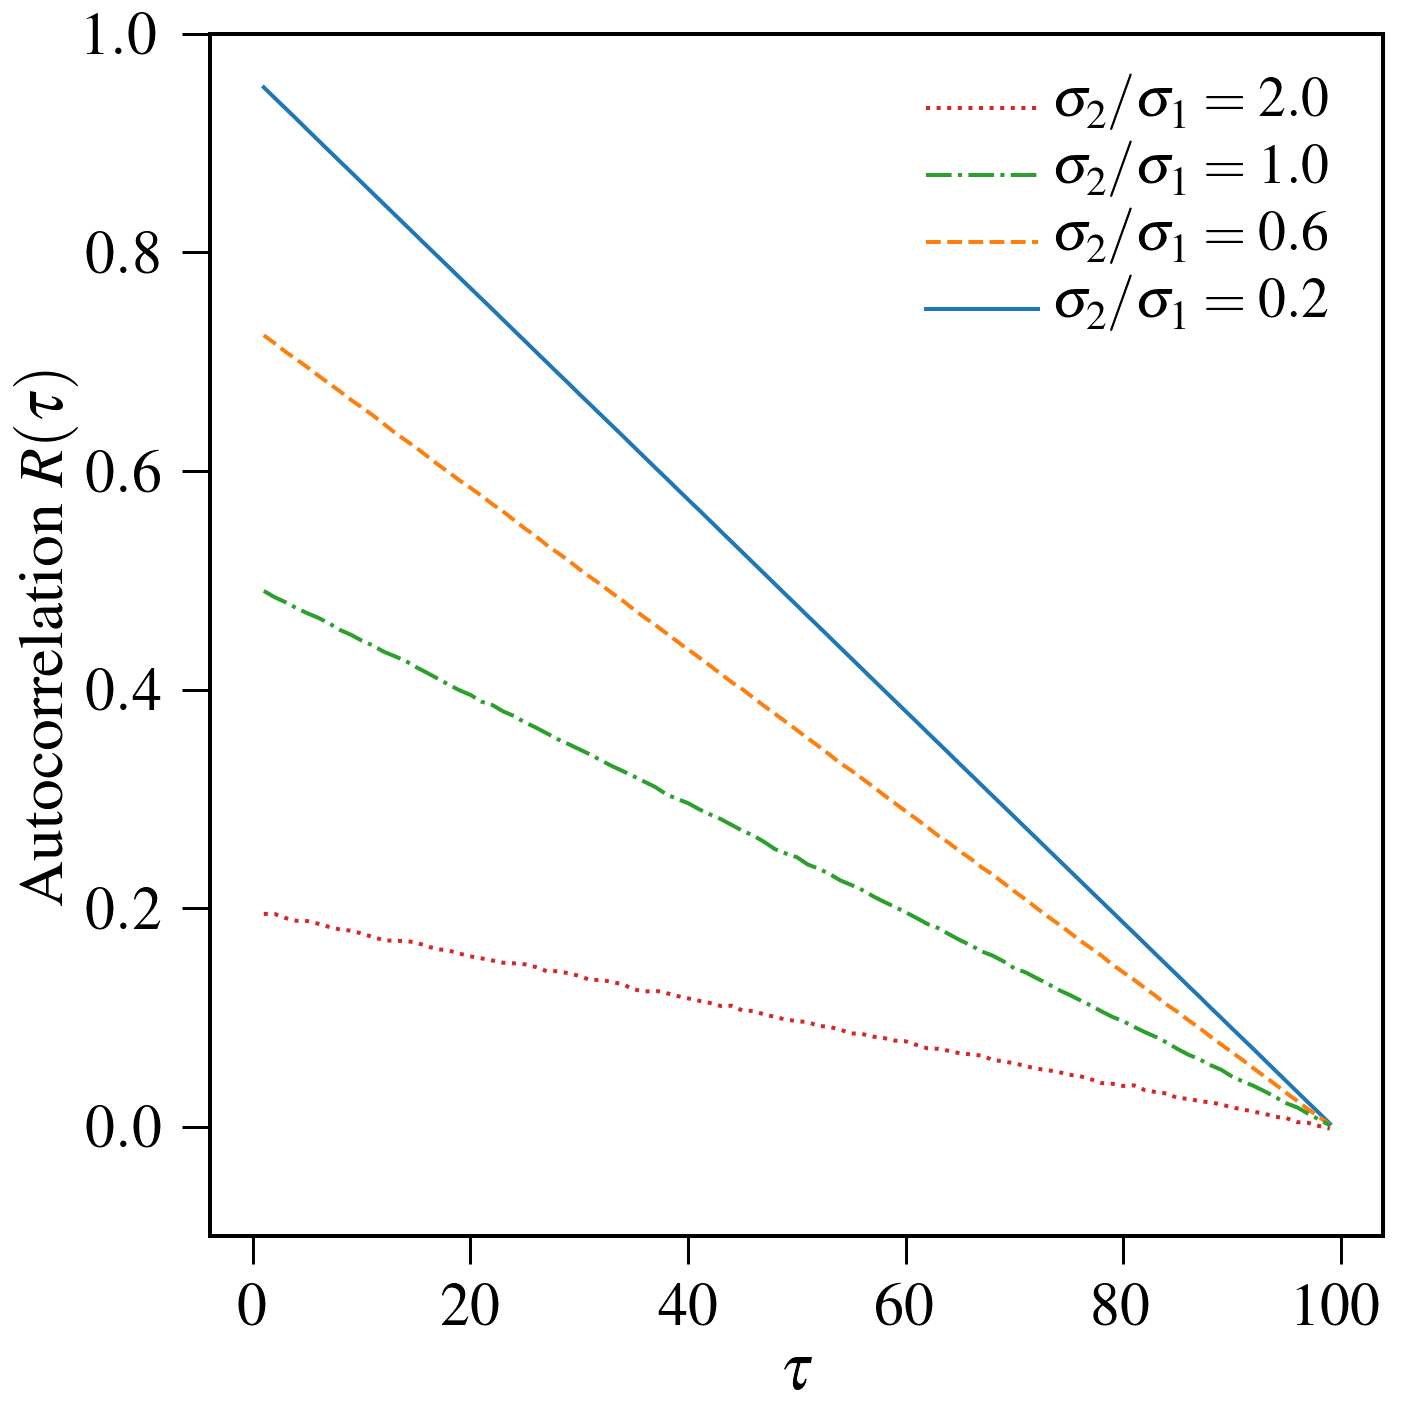

In [7]:
fig = autocorr_stepped(stepped_correlated, s_small_steps)

In [8]:
fig.savefig('autocorr_stepped.pdf')

In [33]:
# Convert to pandas Series and plot
fst = pd.Series(correlated.flatten())
nom = pd.Series(uncorrelated)
df_fast = pd.DataFrame({'var': correlated.flatten(), 'cluster': np.repeat(np.arange(0,10000,1),100)})
df_nominal = pd.DataFrame({'var': uncorrelated})

In [34]:
# Make the normal plots
make(plt_s, fst, nom, 'ReDecay', fst.index.size, nom.index.size, outfile='./dummy_test.pdf')

In [8]:
# Do some bootstrapping
def plot_bs(plt_n, fast, nominal, settings, mod_label='Redecay', n_fast=1, n_nom=1):

    fig = plt.figure(figsize=(10, 10))
    gs = plt.GridSpec(2, 1, height_ratios=[4, 1])
    gspl = gs[0]
    gspu = gs[1]
    ax = fig.add_subplot(gspl)
    pullax = fig.add_subplot(gspu)

    nbins, xmin, xmax = settings.binning
    h_fast = []
    h_integral = []
    for _ in tqdm(range(1000)):
        w = weight_sn(fast)
        h_integral.append(np.sum(w))

        h_temp, edges = np.histogram(fast[plt_n], bins=nbins, range=(xmin, xmax),
                                     weights=w)
        h_fast.append(h_temp)

    print('Integrap: {} + {}'.format(np.mean(h_integral), np.std(h_integral)))
    h_nom, _ = np.histogram(nominal[plt_n], bins=nbins, range=(xmin, xmax))
    x_ctr = (edges[1:] + edges[:-1])/2.
    width = (edges[1:] - edges[:-1])
    x_err = width/2.

    err_fast = np.std(h_fast, axis=0)
    h_fast_m = np.mean(h_fast, axis=0)
    mask = ~(h_fast_m == 0)

    n_effective = 1/(err_fast**2/h_fast_m**2)
    n_effective = np.sum(n_effective[~np.isnan(n_effective)])
    n_real = np.sum(h_fast_m)

    print(plt_n, n_effective, '/', n_real, '=', n_effective/n_real)

    err_nom = np.sqrt(h_nom)

    h_nom = h_nom*1./float(n_nom)
    err_nom = err_nom / float(n_nom)

    h_fast_m = h_fast_m*1./float(n_fast)
    err_fast /= float(n_fast)

    ax.bar(x_ctr-x_err, h_nom, width, color='#D3EFFB',
           label='Nominal', edgecolor='#D3EFFB', align='edge')
    dt_options = dict(
        fmt='o', markersize=5, capthick=1, capsize=0, elinewidth=2,
        color='#006EB6', markeredgecolor='#006EB6')

    ax.errorbar(x_ctr, h_fast_m, yerr=err_fast, xerr=x_err, label=mod_label,
                **dt_options)

    pullax.set_xlim((xmin, xmax))
    extraString = pull_plot(pullax, h_fast_m, h_nom, np.sqrt(err_fast**2 + err_nom**2), width, x_ctr)
    if extraString is not None:
        ax.plot([],[], 'ro', marker=r'$\sigma_{\mathrm{pull}}$', label=extraString, color='black', markersize=40)
        handles, labels = ax.get_legend_handles_labels()
        handles = handles[::-1]
        labels = labels[::-1]
    else:
        handles, labels = ax.get_legend_handles_labels()
        handles = handles[::-1]
        labels = labels[::-1]
    ax.legend(handles, labels, loc='upper right')
    [xtl.set_visible(False) for xtl in ax.get_xticklabels()]
    ax.get_xaxis().get_offset_text().set_visible(False)
    ax.set_xlim((xmin, xmax))
    pullax.set_ylabel(r'$\Delta/\sigma$')

    pullax.set_xlabel(settings.x_label)
    ax.set_ylabel(r'Arbitrary units')
    y_margin_scaler(ax, hf=0.28, lf=0., la=True)
    lhcb_stamp(ax)

    plt.tight_layout()
    gs.tight_layout(fig, pad=0.1)
    return fig, ax, np.array(h_fast).transpose()


def make_bs(plt_n, plt_s, df_fast, df_nominal, mod_label, fst_norm, nom_norm,
         outfile='./dummy_bs.pdf'):
    with PdfPages(outfile) as pdf:
        fig, ax, d = plot_bs(plt_n, df_fast, df_nominal, plt_s, mod_label,
                          fst_norm, nom_norm)
        pdf.savefig(fig)
        try:
            y_margin_scaler(ax, lf=0.00001, hf=0.28, log=True)
            ax.set_yscale("log", nonposy='clip')
            pdf.savefig(fig)
        except:
            pass

        plt.close()
        fig, ax = plt.subplots(figsize=(10, 10))
        sns.heatmap(np.corrcoef(d), ax=ax, vmin=-1, vmax=1, fmt="+2.0f", linewidths=0., yticklabels=[], xticklabels=[], cbar=False)
        pdf.savefig(fig)
        plt.close()
        return d

In [9]:
blub = make_bs(plt_n, plt_s, df_fast, df_nominal, 'ReDecay', df_fast.index.size, df_nominal.index.size, outfile='./dummy_bs_wide.pdf')

100%|██████████| 1000/1000 [02:21<00:00,  6.70it/s]


Integrap: 1000000.0 + 0.0
var 793612.626435 / 977320.324 = 0.812029185259


In [44]:
def plot_step(fast, nominal, settings):

    fig, ax = plt.subplots(figsize=(10, 8))

    nbins, xmin, xmax = settings.binning

    h_fast, edges = np.histogram(fast, bins=nbins, range=(xmin, xmax))
    h_nom, _ = np.histogram(nominal, bins=nbins, range=(xmin, xmax))
    x_ctr = (edges[1:] + edges[:-1])/2.
    width = (edges[1:] - edges[:-1])
    x_err = width/2.

    n_fast = len(fast)
    n_nom = len(nominal)


    h_nom = h_nom*1./float(n_nom)

    h_fast = h_fast*1./float(n_fast)
    mask = h_nom != 0 & (np.abs(x_ctr) < 5)
    h_fast = h_fast/np.max(h_fast[mask]/h_nom[mask])

    ax.bar(x_ctr-x_err, h_nom, width, color='#D3EFFB',
           label='Nominal', edgecolor='#D3EFFB', align='edge')
    ax.bar(x_ctr-x_err, h_fast, width, color='#006EB6',
           label='ReDecay', edgecolor='#006EB6', align='edge')
    

    ax.set_xlabel(settings.x_label)
    handles, labels = ax.get_legend_handles_labels()
    handles = handles[::-1]
    labels = labels[::-1]
    ax.legend(handles, labels, loc='upper right')
    ax.set_xlim((xmin, xmax))
    ax.set_ylabel(r'Arbitrary units')

    y_margin_scaler(ax, hf=0.28, lf=0., la=True)
    return fig, ax

/afs/cern.ch/user/d/dmuller/work/anaconda3/envs/k3pi_python3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


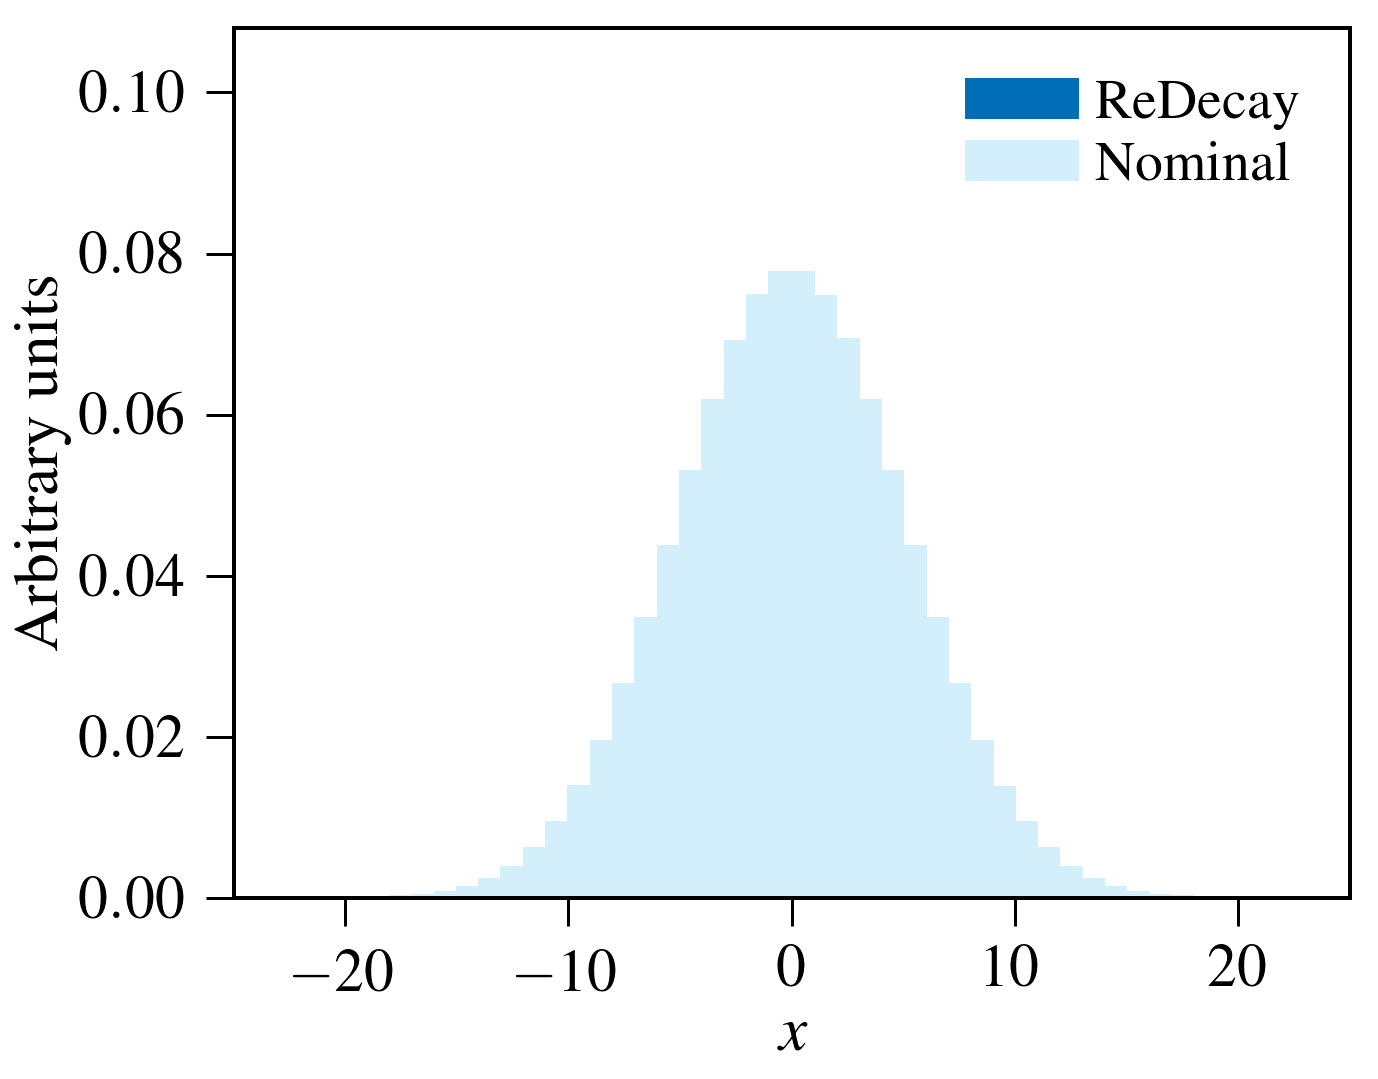

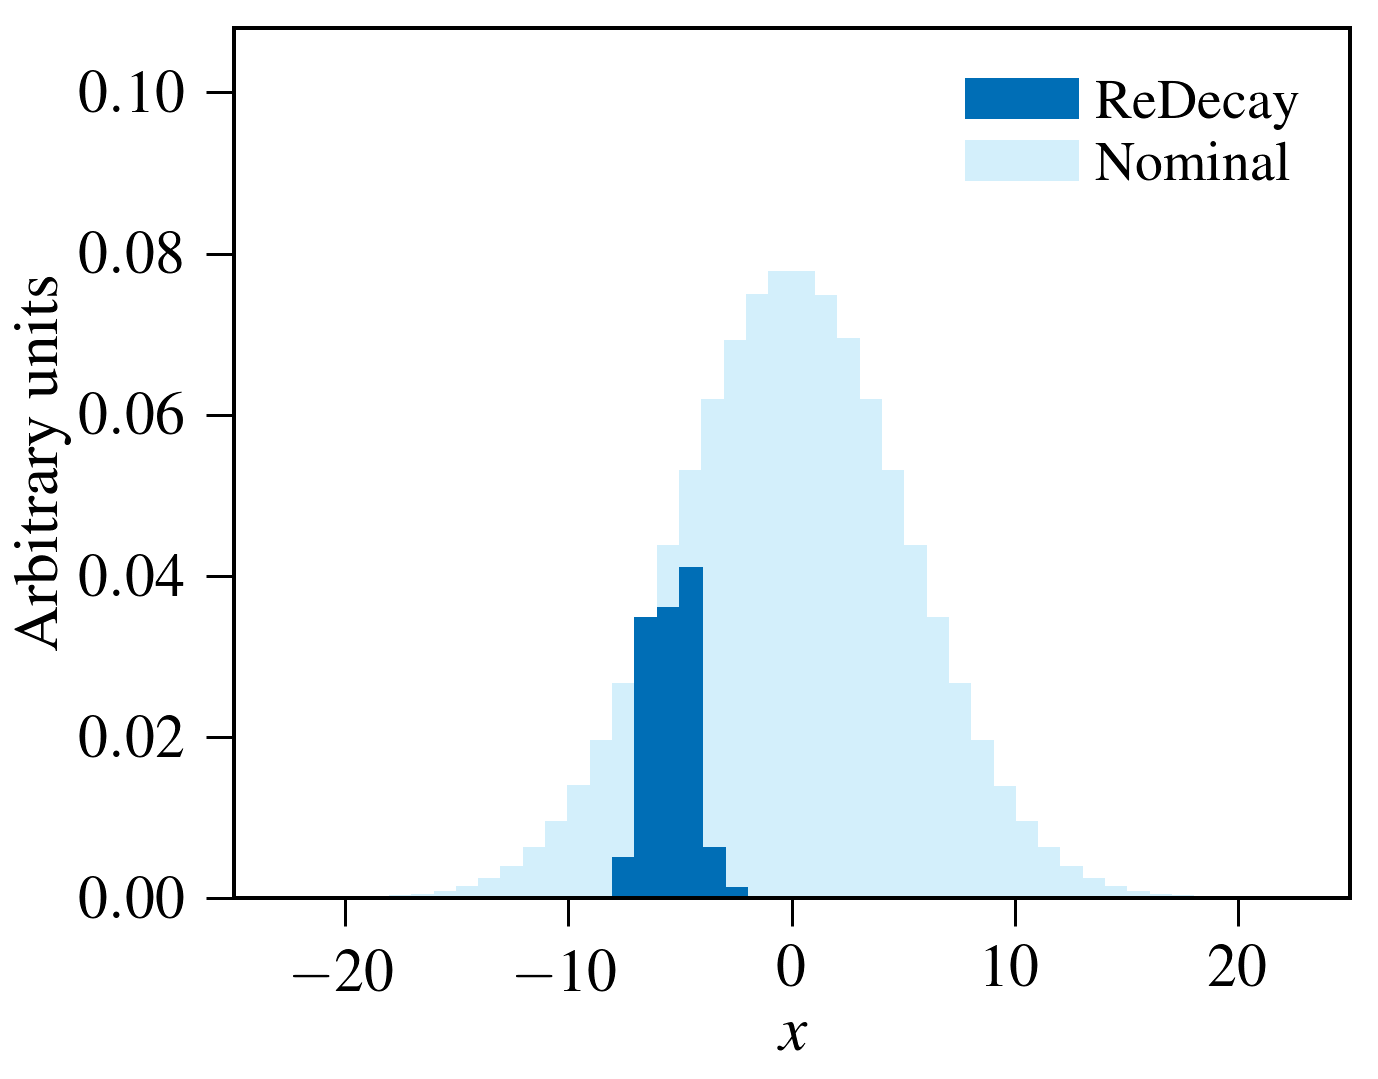

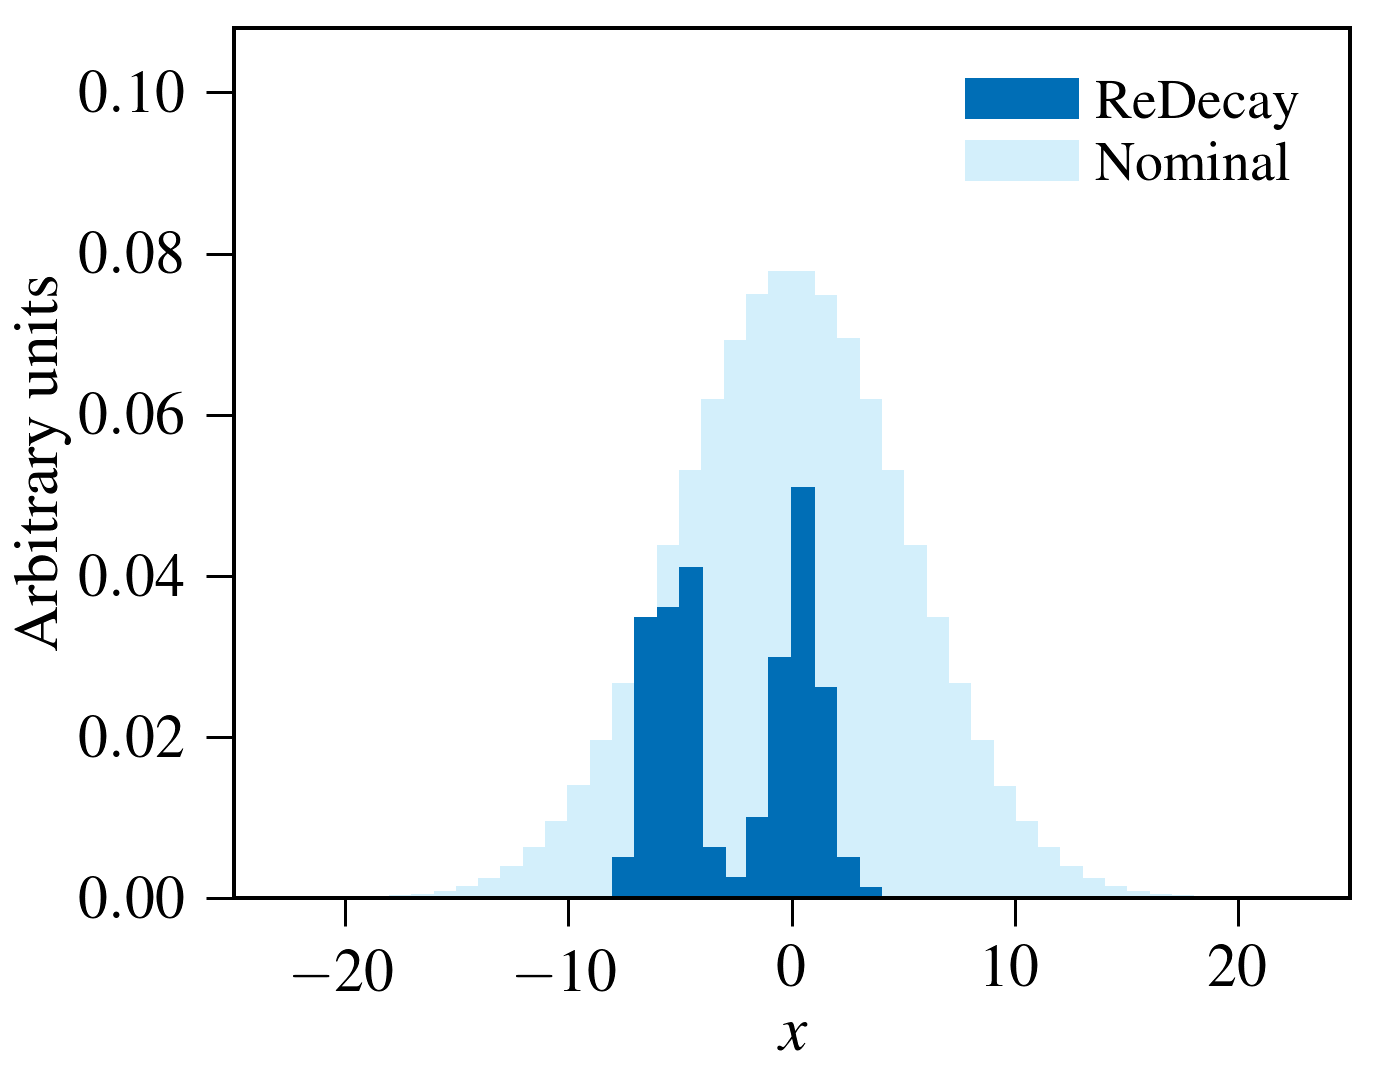

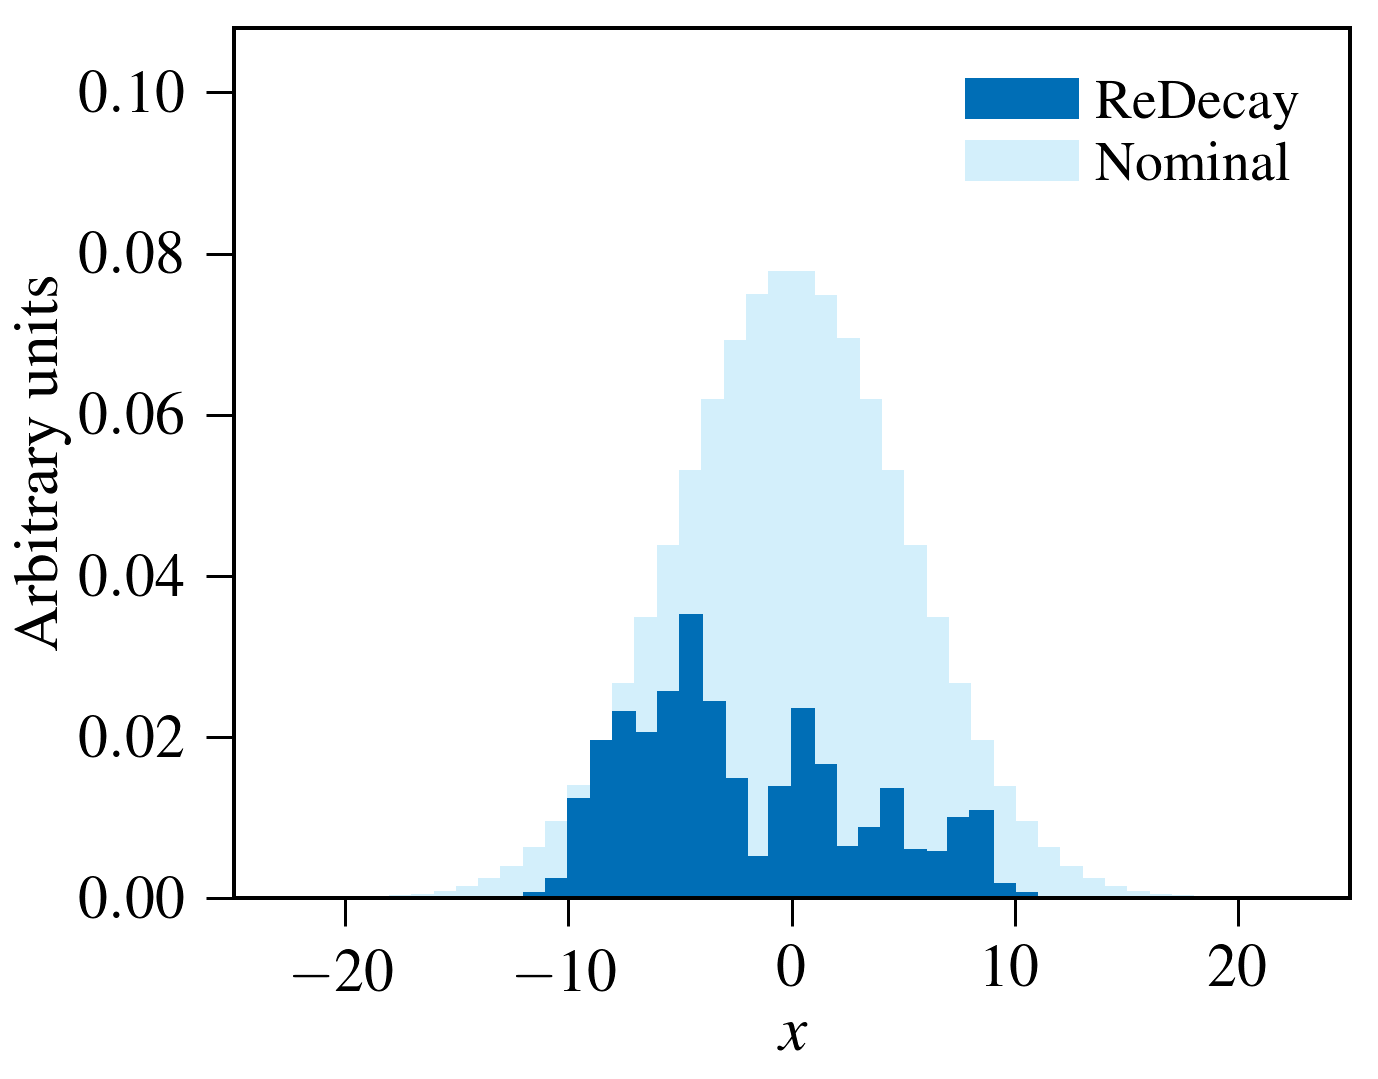

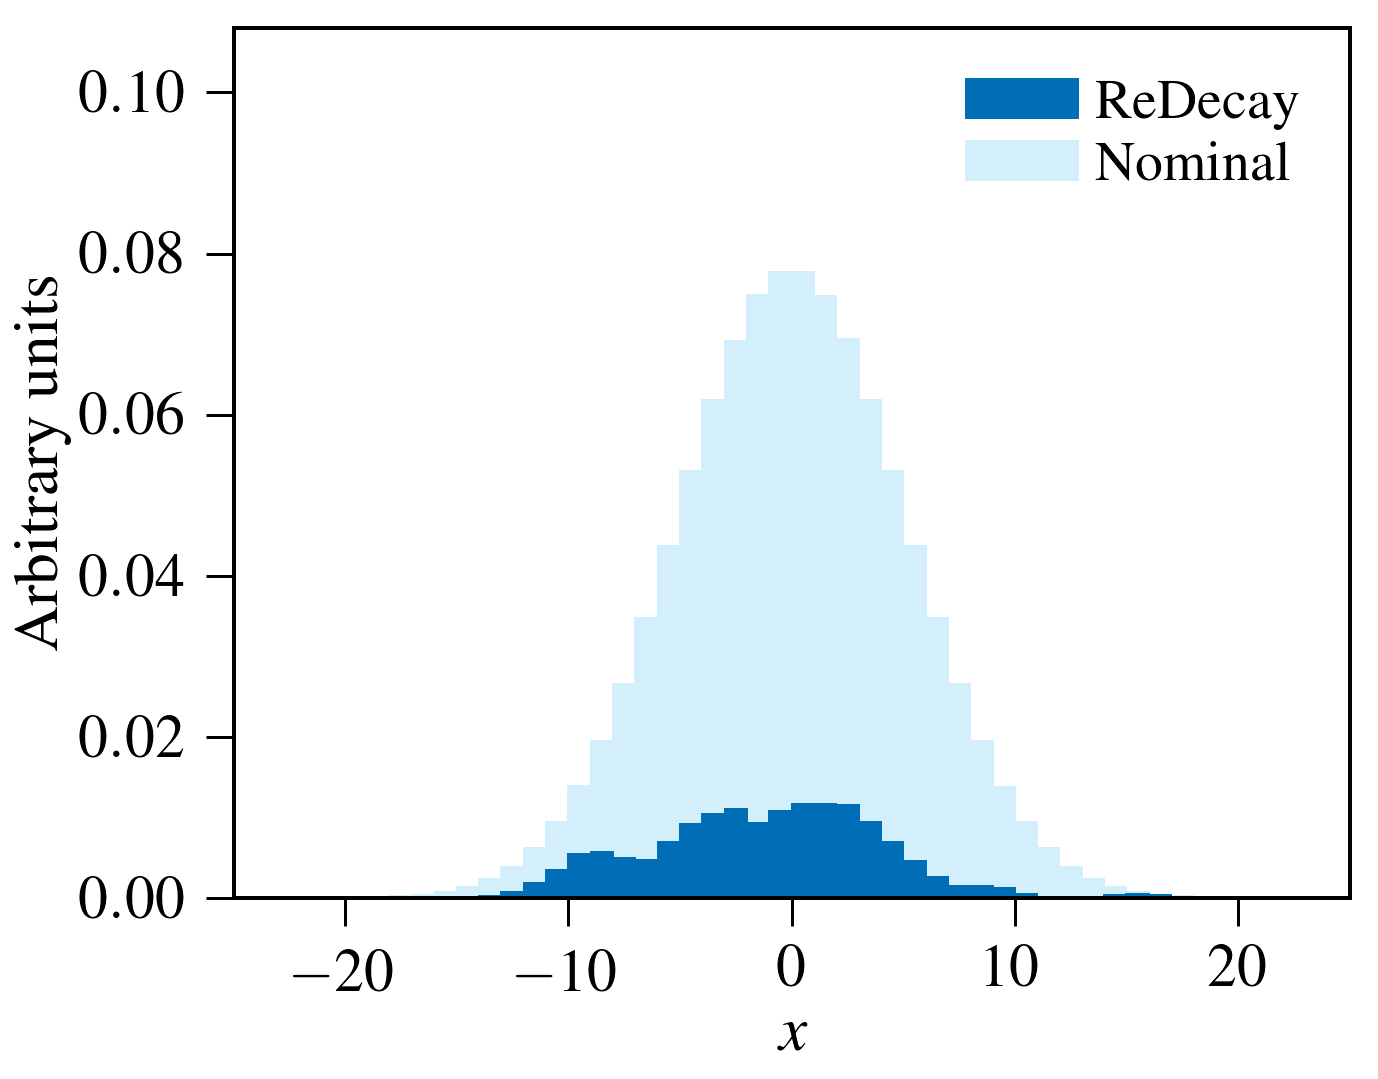

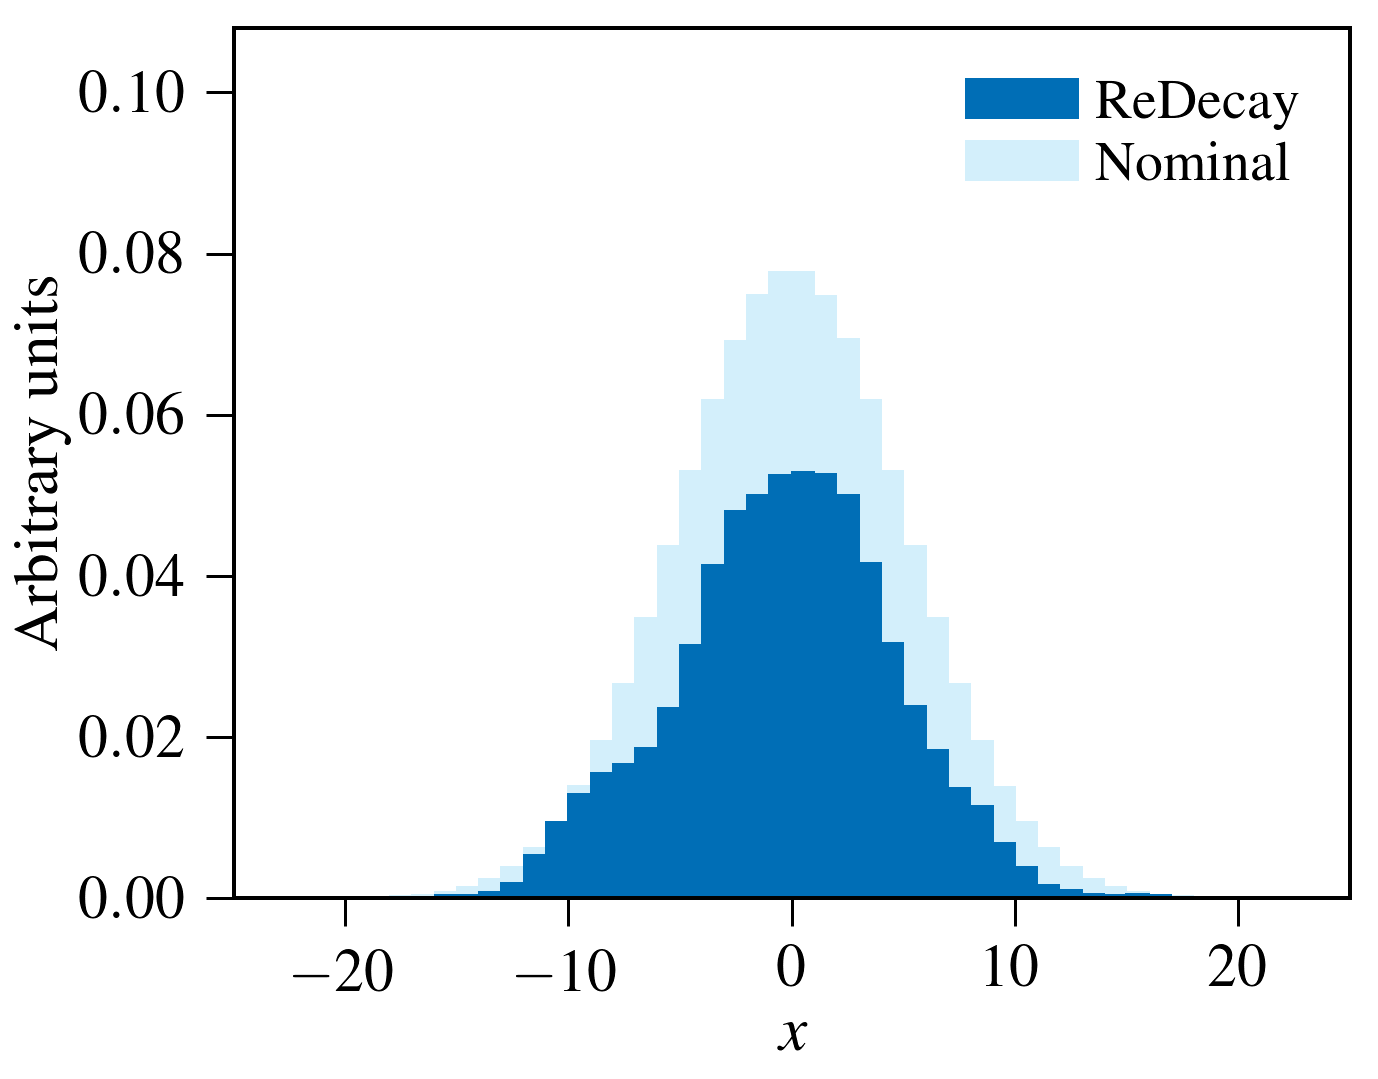

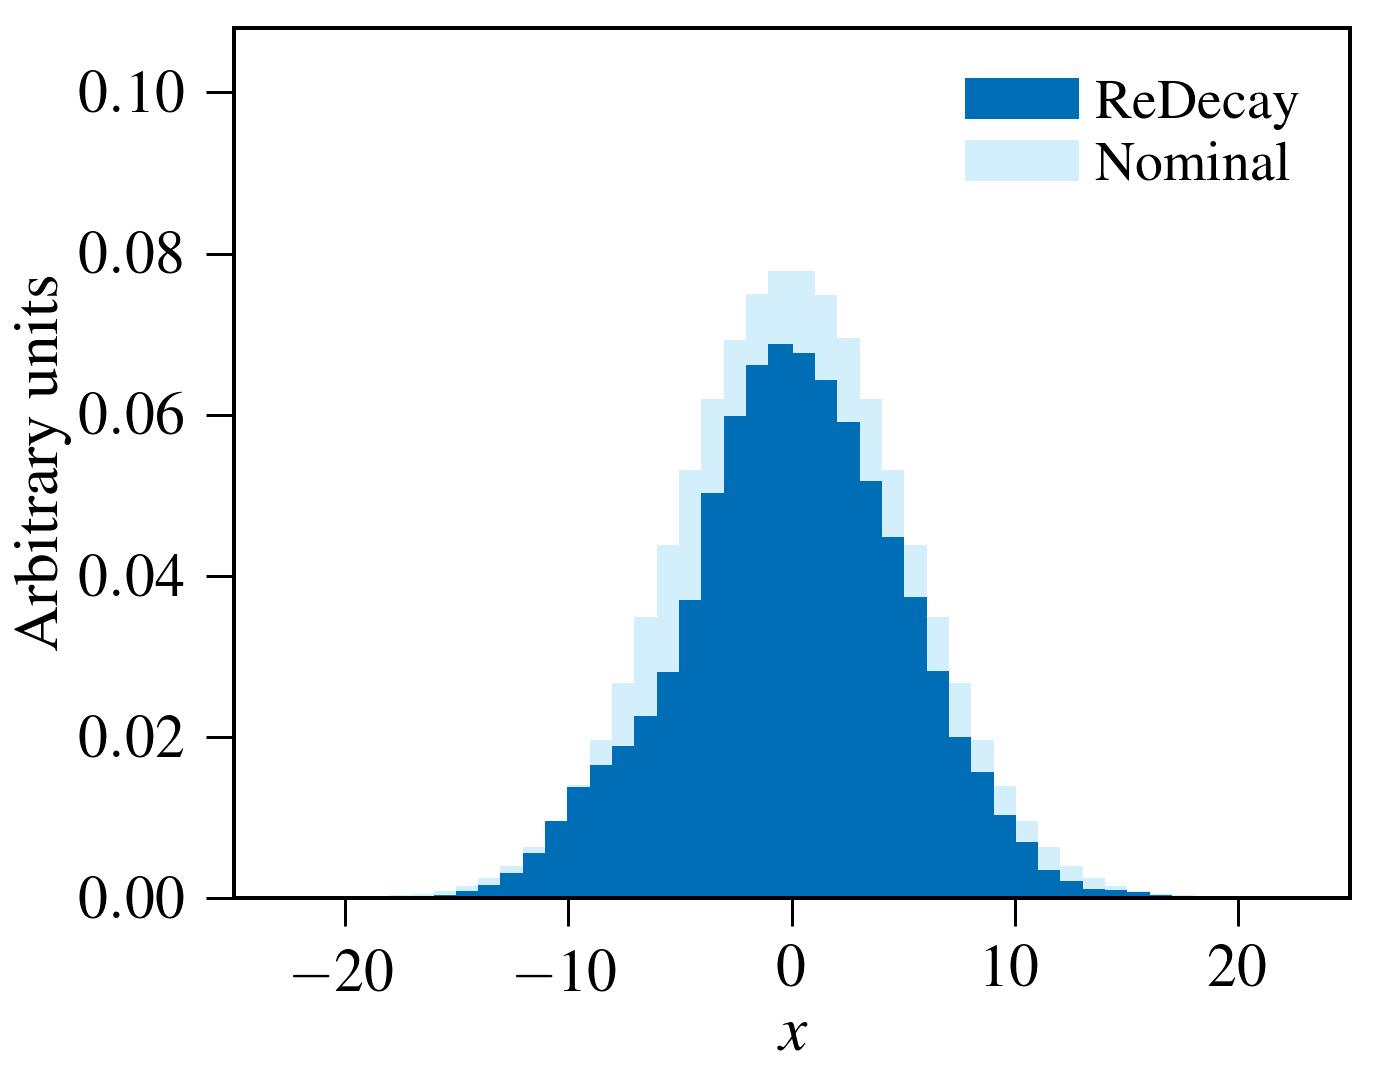

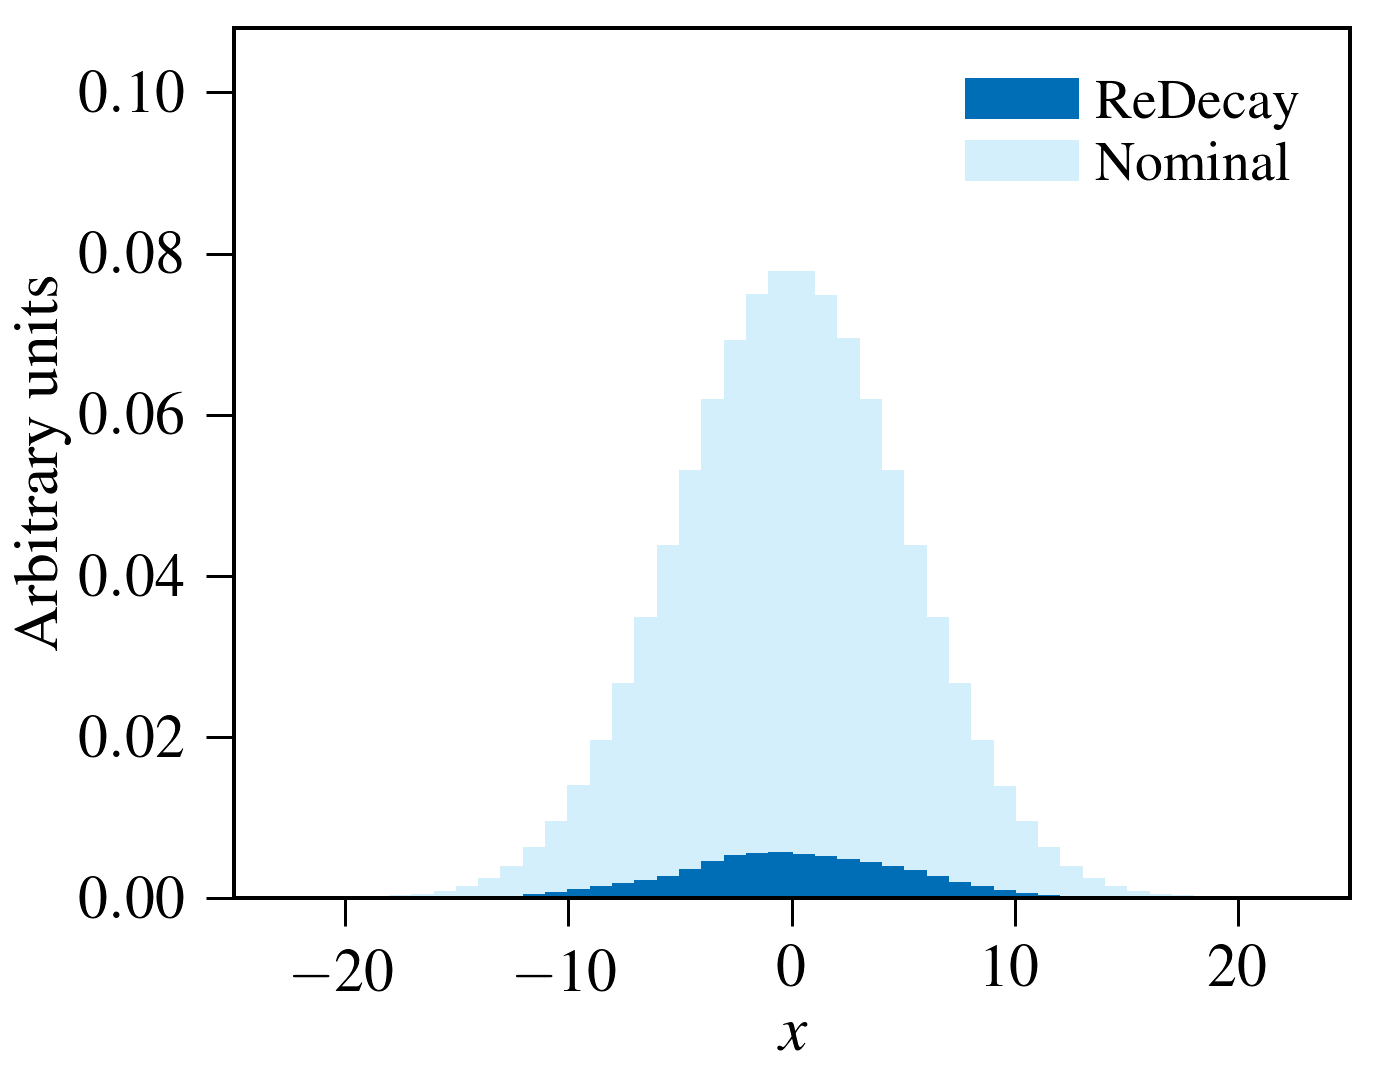

In [49]:
with PdfPages('./dummy_step.pdf') as pdf:
        for ma in [0, 1, 2, 10, 100, 500, 1000, 2000]:
            fig, ax = plot_step(correlated[1:ma+1].flatten(), uncorrelated, plt_s2)
            pdf.savefig(fig)

In [116]:
np.std(np.random.uniform(size=1000000))/np.sqrt(10)

0.091298244007919402

In [67]:
sample

array([ 0.95750312,  0.63520495,  0.86037326,  0.35258469,  0.98411198,
        0.85239427,  0.31221994,  0.35442693,  0.87665801,  0.86148804])

In [76]:
sample = pd.Series(sample)

In [118]:
stuff = []
for i in range(1000):
    stuff +=[np.mean(sample.sample(10, replace=True))]